<a id="toc"></a>
# Antares source modelling
***

Contents :
1. [Creation of SYNED input file (.json)](#syned)
1. [Emission profile](#EP)
1. [Slit scan](#SS)
1. [Advanced tuning curves](#TC)

In [1]:
__author__ = ['Rafael Celestre']
__contact__ = 'rafael.celestre@synchrotron-soleil.fr'
__license__ = 'CC BY-NC-SA 4.0'
__copyright__ = 'Synchrotron SOLEIL, Saint Aubin, France'
__created__ = '24/FEB/2024'
__changed__ = '24/FEB/2024'

import sys

import barc4sr.sr_undulator as und
import barc4xoc.plots as pt
import numpy as np
import pandas as pd
from barc4plots.barc4plots import PlotManager
from barc4sr.aux_energy import energy_wavelength
from barc4sr.sr_classes import ElectronBeam, MagneticStructure, UndulatorSource
from barc4xoc.waves import wavefront_fwxm
from scipy.constants import nano, pico, degree
from copy import copy
# checking we are using the correct python:
print(sys.executable)
print(sys.version)

%load_ext autoreload
%autoreload 2

c:\Users\rafae\miniconda3\envs\dev\python.exe
3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


<a id="syned"></a>
# Creation of SYNED input file (.json)
***

[Back to the top](#toc)

In [2]:
electron_parameters = pd.read_csv(r"C:\Users\rafae\Work\projects\_docs_SOLEIL_upgrade\source\2023-04-26-Dimensions-SOLEIL-actuel-pour-Stephane-BAC.csv", delimiter=";")
electron_parameters.loc[electron_parameters['BeamLineName'].str.contains('ANTARES')]

,BeamLineName,Long_Pos(m),RMS_H_Size(µm),RMS_V_Size(µm),RMS_H_div(µrad),RMS_V_div(µrad),betaX(m),betaZ(m),etax(m),etaxp(-),etaz(m),etazp(-),alphax(-),alphaz(-)
33,ANTARES_1,241.7122,223.2,10.4,30.3,3.9,4.8798,3.5871,0.1733,-0.0024,-0.0060,0.0018,0.3834,0.7477
34,ANTARES_2,244.4367,214.7,8.7,30.3,3.9,4.5353,2.7390,0.1666,-0.0024,-0.0009,0.0018,-0.2570,-0.4364


## current high energy source: HU60 undulator

The HU60 is situated 1.830m upstream the centre of the straight section and is used for the high energy range (70 eV - 1000 eV - 1st harm. We implement HU60 as described in M. E. Couprie et al., AIP Conference Proceedings 519 (2010) - 10.1063/1.3463255.


In [3]:
src_name = "ANTARES_1"

straight_section = ElectronBeam()
straight_section.from_twiss(energy=2.75, energy_spread=0.1025/100, current=0.500,
                emittance=3.94*nano, coupling=1/100,
                beta_x=float(electron_parameters[electron_parameters.BeamLineName == src_name]["betaX(m)"].iloc[0]), 
                eta_x=float(electron_parameters[electron_parameters.BeamLineName == src_name]["etax(m)"].iloc[0]), 
                etap_x=float(electron_parameters[electron_parameters.BeamLineName == src_name]["etaxp(-)"].iloc[0]), 
                alpha_x=float(electron_parameters[electron_parameters.BeamLineName == src_name]["alphax(-)"].iloc[0]),
                beta_y=float(electron_parameters[electron_parameters.BeamLineName == src_name]["betaZ(m)"].iloc[0]), 
                eta_y=float(electron_parameters[electron_parameters.BeamLineName == src_name]["etaz(m)"].iloc[0]), 
                etap_y=float(electron_parameters[electron_parameters.BeamLineName == src_name]["etazp(-)"].iloc[0]), 
                alpha_y=float(electron_parameters[electron_parameters.BeamLineName == src_name]["alphaz(-)"].iloc[0]))

hu60 = MagneticStructure(period_length=60e-3, number_of_periods=26, B_vertical_symmetry=-1, mag_structure='u', centre=-1.830)

current_he_bl = UndulatorSource(electron_beam=straight_section, magnetic_structure=hu60)
current_he_bl.write_syned_config(r".\resources\oasys_soleil_hu60.json", "Soleil - HU60")
current_he_bl.set_undulator(K_vertical=5.55, direction='v', verbose=True)

undulator resonant energy set to 72.978 eV (harm. n°: 1) with:
	>> Bh: 0.000000
	>> Bv: 0.990652
electron beam:
	>> x/xp = 224.92 um vs. 30.38 µrad
	>> y/yp = 13.33 um vs. 4.51 µrad
filament photon beam:
	>> u/up = 35.50 µm vs. 72.01 µrad
photon beam waist positon:
	>> hor. x ver. waist position = 0.000 m vs. 0.000 m
convolved photon beam:
	>> x/xp = 227.70 um vs. 78.15 urad
	>> y/yp = 37.92 um vs. 72.15 urad
central cone size:
	>> 104.36 µrad (Krinsky's def.)
	>> 73.79 µrad (Kim's def.)
	>> 72.01 µrad (Elleaume's approx.)
first radiation ring:
	>> 752.53 µrad
on axis flux:
	>> 2.627e+16 ph/s/mrad²/0.1%bw
flux within the central cone:
	>> 1.797e+15 ph/s/0.1%bw
total integrated power:
	>> 3.663e+03 W


Undulator electron trajectory using SRW: please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ... completed
> Electron trajectory calculation ... completed
completed
>> Total elapsed time: 176.15 ms


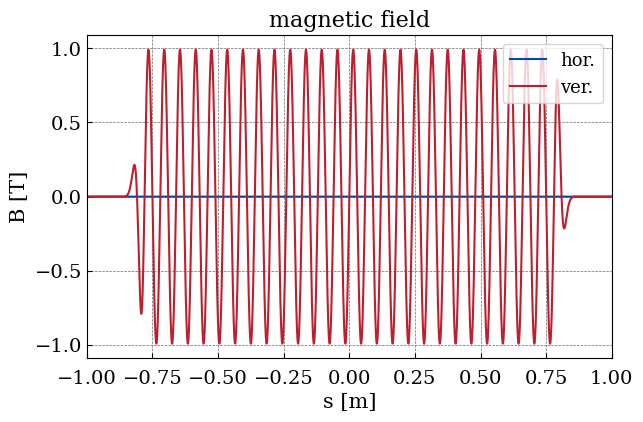

In [4]:
eBeamTraj = und.electron_trajectory(None, light_source=current_he_bl)
pt.plot_magnetic_field(eBeamTraj, xmin=-1., xmax=1.0)

## current low energy source: HU256 undulator

The HU256 is situated 0.8945m donwstream the centre of the straight section and is used for the low energy range (10 eV - 280 eV). We implement HU256 as
described in M. E. Couprie et al., AIP Conference Proceedings 519 (2010) - 10.1063/1.3463255.

In [5]:
src_name = "ANTARES_2"

straight_section = ElectronBeam()
straight_section.from_twiss(energy=2.75, energy_spread=0.1025/100, current=0.500,
                emittance=3.94*nano, coupling=1/100,
                beta_x=float(electron_parameters[electron_parameters.BeamLineName == src_name]["betaX(m)"].iloc[0]), 
                eta_x=float(electron_parameters[electron_parameters.BeamLineName == src_name]["etax(m)"].iloc[0]), 
                etap_x=float(electron_parameters[electron_parameters.BeamLineName == src_name]["etaxp(-)"].iloc[0]), 
                alpha_x=float(electron_parameters[electron_parameters.BeamLineName == src_name]["alphax(-)"].iloc[0]),
                beta_y=float(electron_parameters[electron_parameters.BeamLineName == src_name]["betaZ(m)"].iloc[0]), 
                eta_y=float(electron_parameters[electron_parameters.BeamLineName == src_name]["etaz(m)"].iloc[0]), 
                etap_y=float(electron_parameters[electron_parameters.BeamLineName == src_name]["etazp(-)"].iloc[0]), 
                alpha_y=float(electron_parameters[electron_parameters.BeamLineName == src_name]["alphaz(-)"].iloc[0]))

hu256 = MagneticStructure(period_length=256e-3, number_of_periods=12, B_vertical_symmetry=-1, mag_structure='u',
                         centre=float(electron_parameters[electron_parameters.BeamLineName == "ANTARES_2"]["Long_Pos(m)"].iloc[0]-
                                      electron_parameters[electron_parameters.BeamLineName == "ANTARES_1"]["Long_Pos(m)"].iloc[0]) + hu60.centre)

current_le_bl = UndulatorSource(electron_beam=straight_section, magnetic_structure=hu256)
current_le_bl.write_syned_config(r".\resources\oasys_soleil_hu256.json", "Soleil - HU256")
current_le_bl.set_undulator(K_vertical=7.9, direction='v', verbose=True)

undulator resonant energy set to 8.711 eV (harm. n°: 1) with:
	>> Bh: 0.000000
	>> Bv: 0.330496
electron beam:
	>> x/xp = 216.46 um vs. 30.38 µrad
	>> y/yp = 10.38 um vs. 4.51 µrad
filament photon beam:
	>> u/up = 144.18 µm vs. 148.52 µrad
photon beam waist positon:
	>> hor. x ver. waist position = 0.000 m vs. 0.000 m
convolved photon beam:
	>> x/xp = 260.08 um vs. 151.60 urad
	>> y/yp = 144.55 um vs. 148.59 urad
central cone size:
	>> 215.25 µrad (Krinsky's def.)
	>> 152.20 µrad (Kim's def.)
	>> 148.52 µrad (Elleaume's approx.)
first radiation ring:
	>> 1054.51 µrad
on axis flux:
	>> 2.856e+15 ph/s/mrad²/0.1%bw
flux within the central cone:
	>> 8.316e+14 ph/s/0.1%bw
total integrated power:
	>> 8.028e+02 W


Undulator electron trajectory using SRW: please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ... completed
> Electron trajectory calculation ... completed
completed
>> Total elapsed time: 157.41 ms


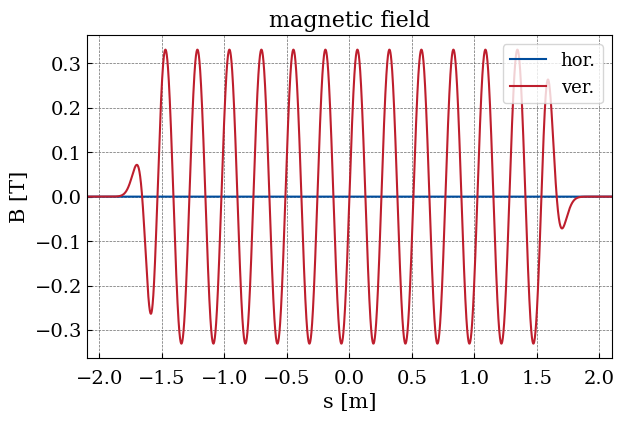

In [6]:
eBeamTraj = und.electron_trajectory(None, light_source=current_le_bl)
pt.plot_magnetic_field(eBeamTraj, xmin=-2.1, xmax=2.1)

## future source (phase I): HU60 undulator (preferred)

The HU60 will be situated at the centre of the straight section and will be used for a reduced energy range (70eV up to 1000eV). We implement HU60 as
described in M. E. Couprie et al., AIP Conference Proceedings 519 (2010) - 10.1063/1.3463255.

In [7]:
straight_section = ElectronBeam()
straight_section.from_twiss(energy=2.75, energy_spread=0.0906/100, current=0.500,
                  emittance_x=85*pico, emittance_y=25.*pico,
                  beta_x=2, eta_x=0, etap_x=0, alpha_x=0,
                  beta_y=2, eta_y=0, etap_y=0, alpha_y=0)
hu60_ph1 = copy(hu60)
hu60_ph1.centre=-270e-3

upgraded_bl_hu60 = UndulatorSource(electron_beam=straight_section, magnetic_structure=hu60_ph1)
upgraded_bl_hu60.write_syned_config(r".\resources\oasys_soleil-ii_hu60.json", "Soleil-II - HU60")
upgraded_bl_hu60.set_undulator(K_vertical=5.55, direction='v', verbose=True)

undulator resonant energy set to 72.978 eV (harm. n°: 1) with:
	>> Bh: 0.000000
	>> Bv: 0.990652
electron beam:
	>> x/xp = 13.04 um vs. 6.52 µrad
	>> y/yp = 7.07 um vs. 3.54 µrad
filament photon beam:
	>> u/up = 35.50 µm vs. 72.01 µrad
photon beam waist positon:
	>> hor. x ver. waist position = 0.000 m vs. 0.000 m
convolved photon beam:
	>> x/xp = 37.82 um vs. 72.30 urad
	>> y/yp = 36.19 um vs. 72.09 urad
central cone size:
	>> 104.36 µrad (Krinsky's def.)
	>> 73.79 µrad (Kim's def.)
	>> 72.01 µrad (Elleaume's approx.)
first radiation ring:
	>> 752.53 µrad
on axis flux:
	>> 2.627e+16 ph/s/mrad²/0.1%bw
flux within the central cone:
	>> 1.797e+15 ph/s/0.1%bw
total integrated power:
	>> 3.663e+03 W


## future source (phase I): HU80 undulator (second option)

The HU80 will be situated at the centre of the straight section and will be used for a reduced energy range (30eV up to 1000eV). We implement HU80 as
described in M. E. Couprie et al., AIP Conference Proceedings 519 (2010) - 10.1063/1.3463255.

In [8]:
hu80 = MagneticStructure(period_length=80e-3, number_of_periods=19, B_vertical_symmetry=-1, mag_structure='u', centre=-270e-3)

upgraded_bl_hu80 = UndulatorSource(electron_beam=straight_section, magnetic_structure=hu80)
upgraded_bl_hu80.write_syned_config(r".\resources\oasys_soleil-ii_hu80.json", "Soleil-II - HU80")
upgraded_bl_hu80.set_undulator(K_vertical=7.92, direction='v', verbose=True)

undulator resonant energy set to 27.738 eV (harm. n°: 1) with:
	>> Bh: 0.000000
	>> Bv: 1.060265
electron beam:
	>> x/xp = 13.04 um vs. 6.52 µrad
	>> y/yp = 7.07 um vs. 3.54 µrad
filament photon beam:
	>> u/up = 56.83 µm vs. 118.32 µrad
photon beam waist positon:
	>> hor. x ver. waist position = 0.000 m vs. 0.000 m
convolved photon beam:
	>> x/xp = 58.31 um vs. 118.50 urad
	>> y/yp = 57.27 um vs. 118.38 urad
central cone size:
	>> 171.48 µrad (Krinsky's def.)
	>> 121.26 µrad (Kim's def.)
	>> 118.32 µrad (Elleaume's approx.)
first radiation ring:
	>> 1057.09 µrad
on axis flux:
	>> 7.126e+15 ph/s/mrad²/0.1%bw
flux within the central cone:
	>> 1.317e+15 ph/s/0.1%bw
total integrated power:
	>> 4.088e+03 W


<a id="EP"></a>
# Emission profile
***

[Back to the top](#toc)

The calculation of the emission profile at several energies allow to calculate the best suited angular acceptance for the beamline


In [9]:
def emission_profile(beamline, E, angular_window, slit_position, **kwargs):

    file_name = kwargs.get('file_name', None)
    fraction = kwargs.get('fraction', 1/np.sqrt(2))

    show = kwargs.get('show', True) 
    process = kwargs.get('process', True) 
    acceptance = kwargs.get('angular_acceptance', None)
    if acceptance is None:
        acceptance = angular_window

    observation_point = slit_position - beamline.centre

    window = np.tan(angular_window/2)*observation_point*2

    wavefront = und.emitted_wavefront(file_name=file_name,
                                photon_energy=E,
                                light_source=beamline,
                                hor_slit=window,
                                ver_slit=window,
                                hor_slit_n=501,
                                ver_slit_n=501,
                                observation_point=observation_point)
    
    if show:
        print(f">>> observation point {observation_point:.3f} m downstream the centre of the straight section")
        pt.plot_wavefront(wavefront, slit_position=observation_point)
    
    if process:
        wft_dict = wavefront_fwxm(wavefront["wavefront"]["intensity"],
                                x=wavefront["axis"]["x"],
                                y=wavefront["axis"]["y"],
                                xth=-1, k=6, slit_position=observation_point)
        ring = 2*beamline.first_ring*fraction
        print(f'> Beam at ± {3} sigma:')
        print(f'>>> {wft_dict["horizontal"]["fwxm"]*1E3:.2f} mrad (horizontal cut)')   
        print(f'>>> {wft_dict["vertical"]["fwxm"]*1E3:.2f} mrad (vertical cut)') 
        print(f'> Beam at ± (first ring)*{fraction:.2f}:')
        print(f'>>> {ring*1E3:.2f} mrad')   

        if show:
            img = PlotManager(wft_dict["horizontal"]["cut"], wft_dict["horizontal"]["axis"]*1E3)
            img.additional_info("profile cut", "[mrad]", "[ph/s/mrad²/0.1%bw]")
            img.aesthetics(400, True, True, 0 , 1, True, 4)
            img.info_1d_plot(0, "horizontal", 0, "-", False, 0, 1).plot_1d(enable=False, hold=False)
            img.image, img.x = wft_dict["vertical"]["cut"], wft_dict["vertical"]["axis"]*1E3
            img.info_1d_plot(1, "vertical", 0, "-", False, 0, 1).plot_1d(enable=False, hold=True)
            if ring > acceptance:
                hwdth = acceptance
                label = 'bl. acceptance'
            else:
                hwdth = ring
                if fraction == 1/np.sqrt(2):
                    label = '(first ring)$/\sqrt{2}$'
                else:
                    label = f'(first ring)$\cdot${fraction:.2f}'

            img.image = [np.amin(wft_dict["averaged"]["cut"]), np.amax(wft_dict["averaged"]["cut"])*.7]
            img.x = [-hwdth*1E3/2, -hwdth*1E3/2]
            img.info_1d_plot(-1, '', 0, ":", False, 0, 0.65).plot_1d(enable=False, hold=True)
            img.image = [np.amin(wft_dict["averaged"]["cut"]), np.amax(wft_dict["averaged"]["cut"])*.7]
            img.x = [hwdth*1E3/2, hwdth*1E3/2]
            img.info_1d_plot(-1, '', 0, ":", False, 0, 0.65).plot_1d(enable=False, hold=True)

            img.image = [np.amax(wft_dict["averaged"]["cut"])/2, np.amax(wft_dict["averaged"]["cut"])/2]
            img.x = [-hwdth*1E3/2, hwdth*1E3/2]
            img.info_1d_plot(-1, label, 1, "x--", False, 0, .75).plot_1d(enable=True, hold=True)

    return wavefront

In [10]:
def power_profile(beamline, angular_window, slit_position, **kwargs):

    file_name = kwargs.get('file_name', None)
    observation_point = slit_position - beamline.centre

    window = np.tan(angular_window/2)*observation_point*2

    power = und.power_density(file_name=file_name,
                              light_source=beamline,
                              hor_slit=window,
                              ver_slit=window,
                              hor_slit_n=501,
                              ver_slit_n=501,
                              observation_point=observation_point)
    
    pt.plot_power(power)
    barc4sr_power = beamline.get_power_through_slit(angular_window, angular_window, npix=251)
    print(f"Power emitted by the undulator through a {angular_window*1E3:.2f} x {angular_window*1E3:.2f} mrad² slit: {power['power_density']['CumPow']:.3f} W")
    print(f">> {barc4sr_power:.3f} W using beamline.get_power_through_slit()")

    return power

def slit_spectrum(beamline, E, nharm, dE, angular_window, slit_position, **kwargs):

    file_name = kwargs.get('file_name', None)
    energy_sampling = kwargs.get('energy_sampling', 0)
    f_min = kwargs.get("f_min", None)
    f_max = kwargs.get("f_max", None)
    pt_min = kwargs.get("pt_min", None)
    pt_max = kwargs.get("pt_max", None)

    observation_point = slit_position - beamline.centre

    ne = kwargs.get('ne', None)
    ei = int(E*.75)
    ef = int(E*(nharm + 0.25))

    ei, ef = int(E*.75), int(E*(nharm + 0.25))

    if ne is None:
        if energy_sampling == 0:
            ne = int((ef-ei)/dE)+1
        else:
            ne = int(1/dE)

    if ef/ei > 15:
        parallel = True
    else:
        parallel = False

    window = np.tan(angular_window/2)*observation_point*2

    spectrum = und.spectrum(file_name=file_name,
                            light_source=beamline,
                            photon_energy_min=ei,
                            photon_energy_max=ef,
                            photon_energy_points=ne,
                            observation_point=observation_point,
                            hor_slit=window,
                            ver_slit=window,
                            parallel = parallel,
                            **kwargs)
    
    pt.plot_spectrum(spectrum, angular_acceptance=angular_window, f_min=f_min, f_max=f_max, pt_min=pt_min, pt_max=pt_max)

### max angular acceptance

In [11]:
def bl_angular_accetance(slit_position, mirror_length, mirror_width, bl, incident_angle):

    proj_mirror = np.sin(incident_angle) * mirror_length  # Projected mirror length

    source2det = [slit_position - src.centre for src in bl]
    window_v = [2 * np.arctan(mirror_width / (2 * d)) for d in source2det]
    window_h = [2 * np.arctan(proj_mirror / (2 * d)) for d in source2det]
    U= [src.period_length*1E3 for src in bl]
    for d, w_h, w_v, undlt in zip(source2det, window_h, window_v, U):
        print(f"Angular acceptance for a source {d:.3f} m upstream the slit (U{undlt:.0f}):")
        print(f"{w_h * 1E3:.3f} (h) × {w_v * 1E3:.3f} (v) mrad²")

    return window_h, window_v

In [12]:
slit_position = 20
mirror_length, mirror_width = 126e-3, 14.0e-3
sources = [current_he_bl, current_le_bl, upgraded_bl_hu60, upgraded_bl_hu80]

In [13]:
angle = 2.5
window_h, window_v = bl_angular_accetance(slit_position, mirror_length, mirror_width, sources, angle * degree)

Angular acceptance for a source 21.830 m upstream the slit (U60):
0.252 (h) × 0.641 (v) mrad²
Angular acceptance for a source 19.105 m upstream the slit (U256):
0.288 (h) × 0.733 (v) mrad²
Angular acceptance for a source 20.270 m upstream the slit (U60):
0.271 (h) × 0.691 (v) mrad²
Angular acceptance for a source 20.270 m upstream the slit (U80):
0.271 (h) × 0.691 (v) mrad²


In [14]:
angle = 5.0
window_h, window_v = bl_angular_accetance(slit_position, mirror_length, mirror_width, sources, angle * degree)

Angular acceptance for a source 21.830 m upstream the slit (U60):
0.503 (h) × 0.641 (v) mrad²
Angular acceptance for a source 19.105 m upstream the slit (U256):
0.575 (h) × 0.733 (v) mrad²
Angular acceptance for a source 20.270 m upstream the slit (U60):
0.542 (h) × 0.691 (v) mrad²
Angular acceptance for a source 20.270 m upstream the slit (U80):
0.542 (h) × 0.691 (v) mrad²


In [15]:
dE = 1/5001
fE = 35000

wavefront = True
power = True
spectrum = True

harmonic = None

design_aperture = 1e-3
angular_window = 0.7e-3

## current high energy source: HU60 undulator

In [16]:
beamline = current_he_bl
angular_acceptance = np.amin([window_v[0], window_h[0], design_aperture])

undulator resonant energy set to 70.000 eV (harm. n°: 1) with:
	>> Kh: 0.000000
	>> Kv: 5.674340
electron beam:
	>> x/xp = 224.92 um vs. 30.38 µrad
	>> y/yp = 13.33 um vs. 4.51 µrad
filament photon beam:
	>> u/up = 36.24 µm vs. 73.52 µrad
photon beam waist positon:
	>> hor. x ver. waist position = 0.000 m vs. 0.000 m
convolved photon beam:
	>> x/xp = 227.82 um vs. 79.55 urad
	>> y/yp = 38.62 um vs. 73.66 urad
central cone size:
	>> 106.55 µrad (Krinsky's def.)
	>> 75.35 µrad (Kim's def.)
	>> 73.52 µrad (Elleaume's approx.)
first radiation ring:
	>> 768.38 µrad
on axis flux:
	>> 2.520e+16 ph/s/mrad²/0.1%bw
flux within the central cone:
	>> 1.798e+15 ph/s/0.1%bw
total integrated power:
	>> 3.829e+03 W
Undulator spatial distribution for a given energy using SRW: please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ... completed
> Electron trajectory calculation ... completed
> Performing monochromatic wavefront calculation (simplified partially-c

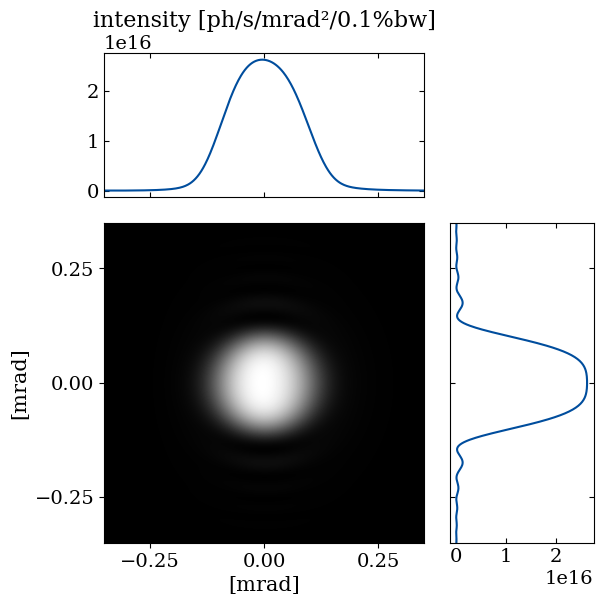

> Beam at ± 3 sigma:
>>> 0.68 mrad (horizontal cut)
>>> 0.67 mrad (vertical cut)
> Beam at ± (first ring)*0.71:
>>> 1.09 mrad


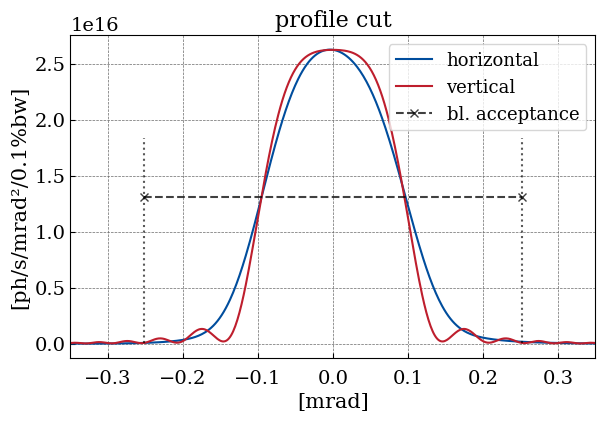

Undulator power density spatial distribution using SRW. Please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ... completed
> Electron trajectory calculation ... completed
> Undulator power density spatial distribution using SRW ... completed
Total received power: 1096.828 W
Peak power density: 17.565 W/mm^2
Undulator power density spatial distribution using SRW: finished
>> Total elapsed time: 41.57 s


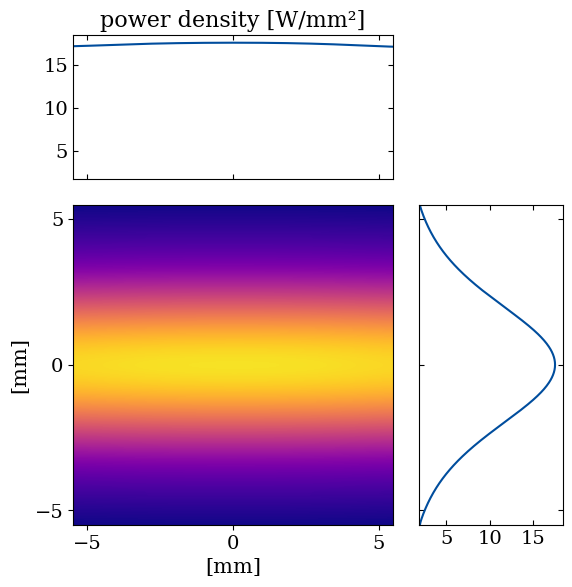

Power emitted by the undulator through a 0.50 x 0.50 mrad² slit: 1096.828 W
>> 1065.936 W using beamline.get_power_through_slit()
Undulator spectrum calculation using SRW: please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ... completed
> Electron trajectory calculation ... completed
>>> generate_logarithmic_energy_values - number of steps: 5241 (-240.0 and 5001.0) around E0 with step size 1.243e-03
> Performing flux through finite aperture (simplified partially-coherent simulation) in parallel... 
>>> elapsed time:
 Core 1: 10.73 s for 437 pts (E0 = 51.9 eV).
 Core 2: 6.82 s for 437 pts (E0 = 89.4 eV).
 Core 3: 4.97 s for 437 pts (E0 = 153.9 eV).
 Core 4: 3.01 s for 437 pts (E0 = 264.9 eV).
 Core 5: 8.86 s for 437 pts (E0 = 456.0 eV).
 Core 6: 22.10 s for 437 pts (E0 = 785.0 eV).
 Core 7: 52.99 s for 437 pts (E0 = 1351.2 eV).
 Core 8: 133.86 s for 437 pts (E0 = 2325.9 eV).
 Core 9: 345.46 s for 437 pts (E0 = 4003.6 eV).
 Core 10: 1041.48 s 

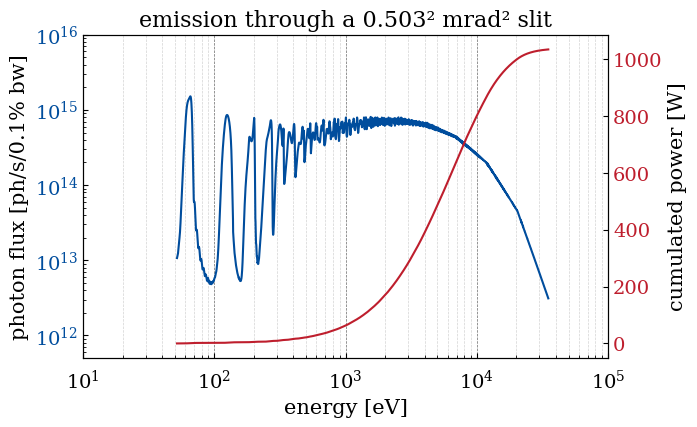

Undulator spectrum calculation using SRW: please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ... completed
> Electron trajectory calculation ... completed
>>> generate_logarithmic_energy_values - number of steps: 5241 (-240.0 and 5001.0) around E0 with step size 1.243e-03
> Performing flux through finite aperture (simplified partially-coherent simulation) in parallel... 
>>> elapsed time:
 Core 1: 5.07 s for 437 pts (E0 = 51.9 eV).
 Core 2: 2.78 s for 437 pts (E0 = 89.4 eV).
 Core 3: 1.46 s for 437 pts (E0 = 153.9 eV).
 Core 4: 1.71 s for 437 pts (E0 = 264.9 eV).
 Core 5: 3.94 s for 437 pts (E0 = 456.0 eV).
 Core 6: 8.87 s for 437 pts (E0 = 785.0 eV).
 Core 7: 25.45 s for 437 pts (E0 = 1351.2 eV).
 Core 8: 64.77 s for 437 pts (E0 = 2325.9 eV).
 Core 9: 184.64 s for 437 pts (E0 = 4003.6 eV).
 Core 10: 485.46 s for 437 pts (E0 = 6891.5 eV).
 Core 11: 1238.02 s for 436 pts (E0 = 11862.5 eV).
 Core 12: 3082.39 s for 436 pts (E0 = 20393.8 eV).
co

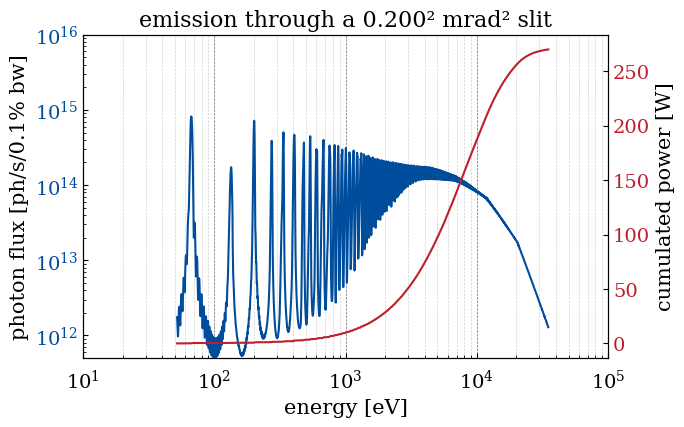

In [17]:
E = 70
nharm = int(fE/E)
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)
if power: power_profile(beamline, angular_acceptance, slit_position)
if spectrum: slit_spectrum(beamline, E, nharm, dE, np.min([angular_acceptance, 2*beamline.first_ring/np.sqrt(2)]), slit_position, energy_sampling=1, fmin=20, fmax=25000, pt_min=0.5E12, pt_max=1E16)
if spectrum: slit_spectrum(beamline, E, nharm, dE, 0.2E-3, slit_position, energy_sampling=1, fmin=20, fmax=25000, pt_min=0.5E12, pt_max=1E16)

undulator resonant energy set to 280.000 eV (harm. n°: 1) with:
	>> Kh: 0.000000
	>> Kv: 2.559206
electron beam:
	>> x/xp = 224.92 um vs. 30.38 µrad
	>> y/yp = 13.33 um vs. 4.51 µrad
filament photon beam:
	>> u/up = 18.12 µm vs. 36.76 µrad
photon beam waist positon:
	>> hor. x ver. waist position = 0.000 m vs. 0.000 m
convolved photon beam:
	>> x/xp = 225.65 um vs. 47.69 urad
	>> y/yp = 22.50 um vs. 37.04 urad
central cone size:
	>> 53.28 µrad (Krinsky's def.)
	>> 37.67 µrad (Kim's def.)
	>> 36.76 µrad (Elleaume's approx.)
first radiation ring:
	>> 384.19 µrad
on axis flux:
	>> 9.614e+16 ph/s/mrad²/0.1%bw
flux within the central cone:
	>> 1.715e+15 ph/s/0.1%bw
total integrated power:
	>> 7.788e+02 W
Undulator spatial distribution for a given energy using SRW: please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ... completed
> Electron trajectory calculation ... completed
> Performing monochromatic wavefront calculation (simplified partially-c

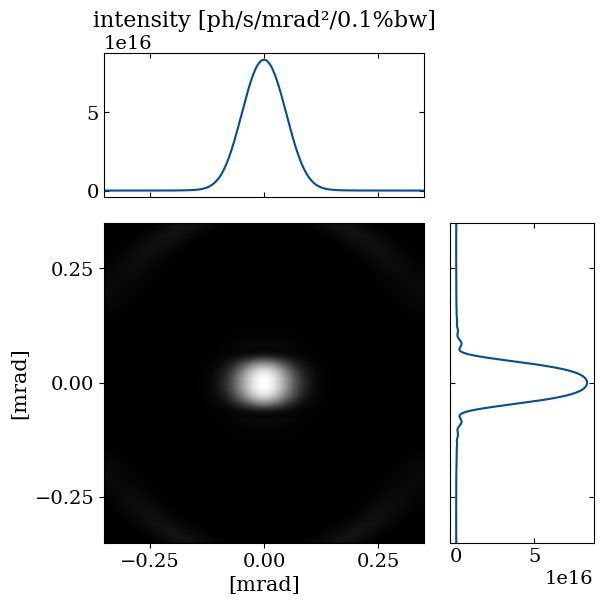

> Beam at ± 3 sigma:
>>> 0.39 mrad (horizontal cut)
>>> 0.31 mrad (vertical cut)
> Beam at ± (first ring)*0.71:
>>> 0.54 mrad


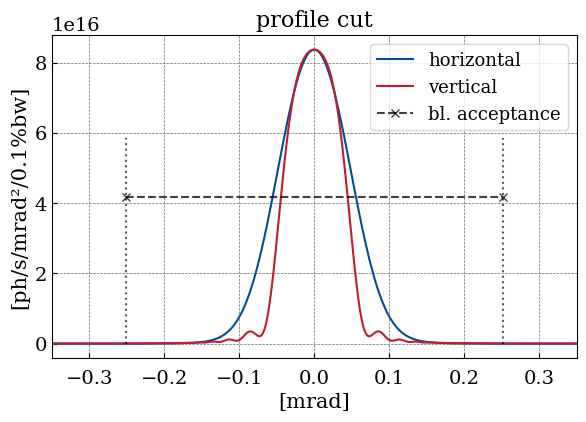

In [18]:
E = 280
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)

undulator resonant energy set to 500.000 eV (harm. n°: 1) with:
	>> Kh: 0.000000
	>> Kv: 1.669652
electron beam:
	>> x/xp = 224.92 um vs. 30.38 µrad
	>> y/yp = 13.33 um vs. 4.51 µrad
filament photon beam:
	>> u/up = 13.56 µm vs. 27.51 µrad
photon beam waist positon:
	>> hor. x ver. waist position = 0.000 m vs. 0.000 m
convolved photon beam:
	>> x/xp = 225.33 um vs. 40.98 urad
	>> y/yp = 19.02 um vs. 27.88 urad
central cone size:
	>> 39.87 µrad (Krinsky's def.)
	>> 28.19 µrad (Kim's def.)
	>> 27.51 µrad (Elleaume's approx.)
first radiation ring:
	>> 287.50 µrad
on axis flux:
	>> 1.512e+17 ph/s/mrad²/0.1%bw
flux within the central cone:
	>> 1.510e+15 ph/s/0.1%bw
total integrated power:
	>> 3.315e+02 W
Undulator spatial distribution for a given energy using SRW: please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ... completed
> Electron trajectory calculation ... completed
> Performing monochromatic wavefront calculation (simplified partially-c

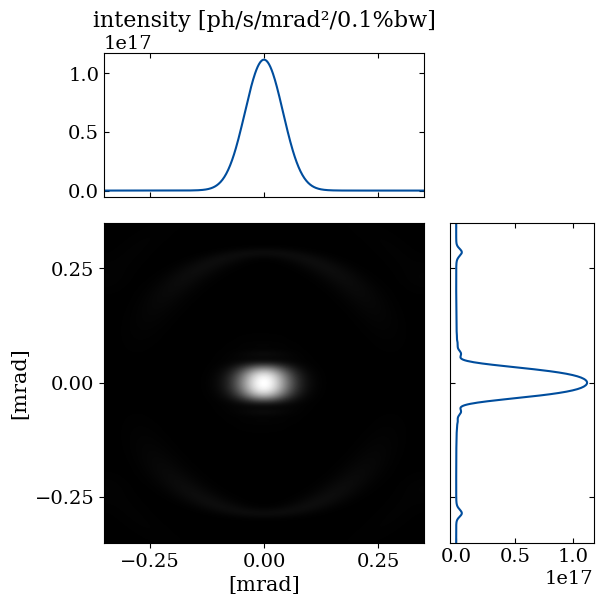

> Beam at ± 3 sigma:
>>> 0.34 mrad (horizontal cut)
>>> 0.23 mrad (vertical cut)
> Beam at ± (first ring)*0.71:
>>> 0.41 mrad


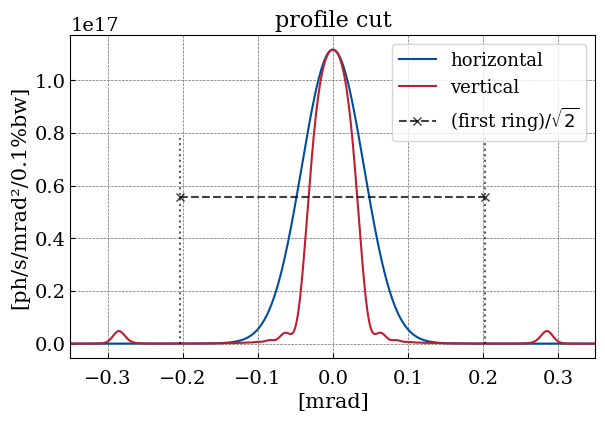

In [19]:
E = 500
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)

undulator resonant energy set to 900.000 eV (harm. n°: 1) with:
	>> Kh: 0.000000
	>> Kv: 0.812315
electron beam:
	>> x/xp = 224.92 um vs. 30.38 µrad
	>> y/yp = 13.33 um vs. 4.51 µrad
filament photon beam:
	>> u/up = 10.11 µm vs. 20.50 µrad
photon beam waist positon:
	>> hor. x ver. waist position = 0.000 m vs. 0.000 m
convolved photon beam:
	>> x/xp = 225.15 um vs. 36.65 urad
	>> y/yp = 16.73 um vs. 21.00 urad
central cone size:
	>> 29.72 µrad (Krinsky's def.)
	>> 21.01 µrad (Kim's def.)
	>> 20.50 µrad (Elleaume's approx.)
first radiation ring:
	>> 214.29 µrad
on axis flux:
	>> 1.452e+17 ph/s/mrad²/0.1%bw
flux within the central cone:
	>> 8.056e+14 ph/s/0.1%bw
total integrated power:
	>> 7.846e+01 W
Undulator spatial distribution for a given energy using SRW: please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ... completed
> Electron trajectory calculation ... completed
> Performing monochromatic wavefront calculation (simplified partially-c

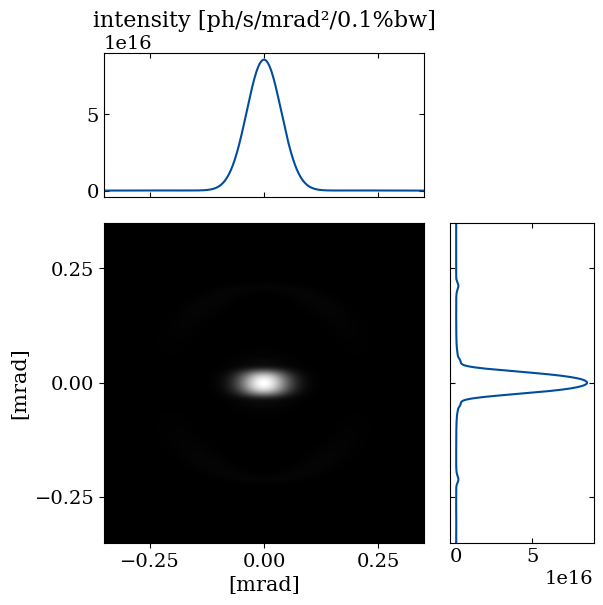

> Beam at ± 3 sigma:
>>> 0.31 mrad (horizontal cut)
>>> 0.17 mrad (vertical cut)
> Beam at ± (first ring)*0.71:
>>> 0.30 mrad


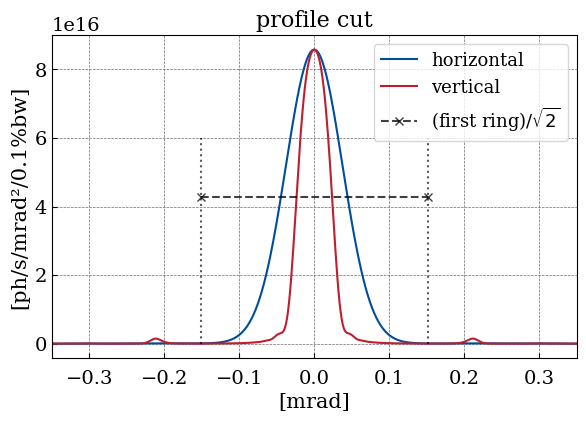

In [20]:
E = 900
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)

undulator resonant energy set to 1000.000 eV (harm. n°: 1) with:
	>> Kh: 0.000000
	>> Kv: 0.627590
electron beam:
	>> x/xp = 224.92 um vs. 30.38 µrad
	>> y/yp = 13.33 um vs. 4.51 µrad
filament photon beam:
	>> u/up = 9.59 µm vs. 19.45 µrad
photon beam waist positon:
	>> hor. x ver. waist position = 0.000 m vs. 0.000 m
convolved photon beam:
	>> x/xp = 225.13 um vs. 36.07 urad
	>> y/yp = 16.42 um vs. 19.97 urad
central cone size:
	>> 28.19 µrad (Krinsky's def.)
	>> 19.93 µrad (Kim's def.)
	>> 19.45 µrad (Elleaume's approx.)
first radiation ring:
	>> 203.29 µrad
on axis flux:
	>> 1.123e+17 ph/s/mrad²/0.1%bw
flux within the central cone:
	>> 5.608e+14 ph/s/0.1%bw
total integrated power:
	>> 4.683e+01 W
Undulator spatial distribution for a given energy using SRW: please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ... completed
> Electron trajectory calculation ... completed
> Performing monochromatic wavefront calculation (simplified partially-c

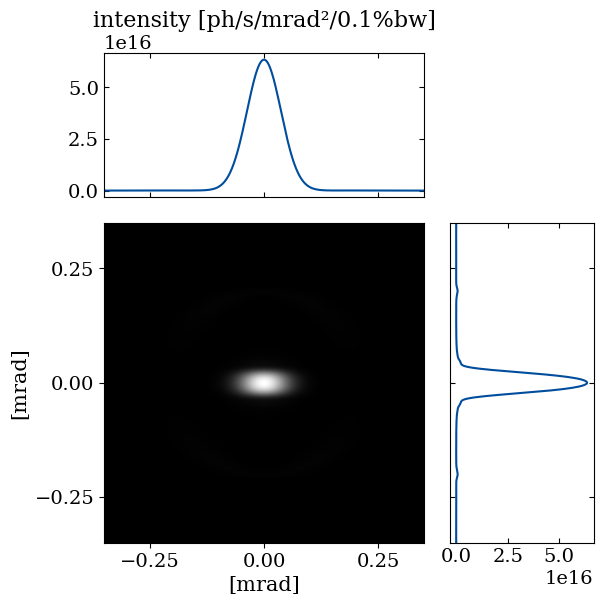

> Beam at ± 3 sigma:
>>> 0.31 mrad (horizontal cut)
>>> 0.16 mrad (vertical cut)
> Beam at ± (first ring)*0.71:
>>> 0.29 mrad


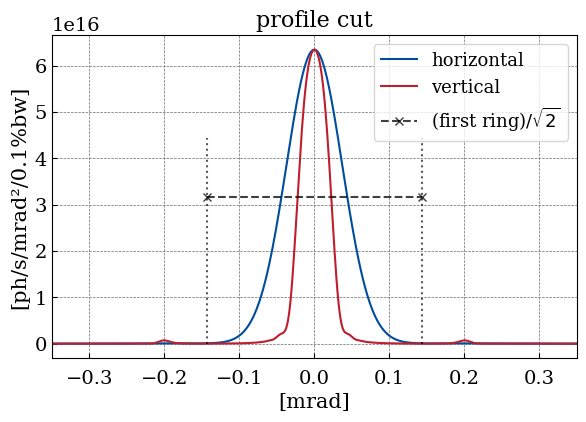

In [21]:
E = 1000
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)

## current low energy source: HU256 undulator

In [22]:
beamline = current_le_bl
angular_acceptance = np.amin([window_v[1], window_h[1], design_aperture])

undulator resonant energy set to 10.000 eV (harm. n°: 1) with:
	>> Kh: 0.000000
	>> Kv: 7.355699
electron beam:
	>> x/xp = 216.46 um vs. 30.38 µrad
	>> y/yp = 10.38 um vs. 4.51 µrad
filament photon beam:
	>> u/up = 134.57 µm vs. 138.62 µrad
photon beam waist positon:
	>> hor. x ver. waist position = 0.000 m vs. 0.000 m
convolved photon beam:
	>> x/xp = 254.87 um vs. 141.91 urad
	>> y/yp = 134.97 um vs. 138.69 urad
central cone size:
	>> 200.90 µrad (Krinsky's def.)
	>> 142.06 µrad (Kim's def.)
	>> 138.62 µrad (Elleaume's approx.)
first radiation ring:
	>> 984.19 µrad
on axis flux:
	>> 3.278e+15 ph/s/mrad²/0.1%bw
flux within the central cone:
	>> 8.313e+14 ph/s/0.1%bw
total integrated power:
	>> 6.959e+02 W
Undulator spatial distribution for a given energy using SRW: please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ... completed
> Electron trajectory calculation ... completed
> Performing monochromatic wavefront calculation (simplified part

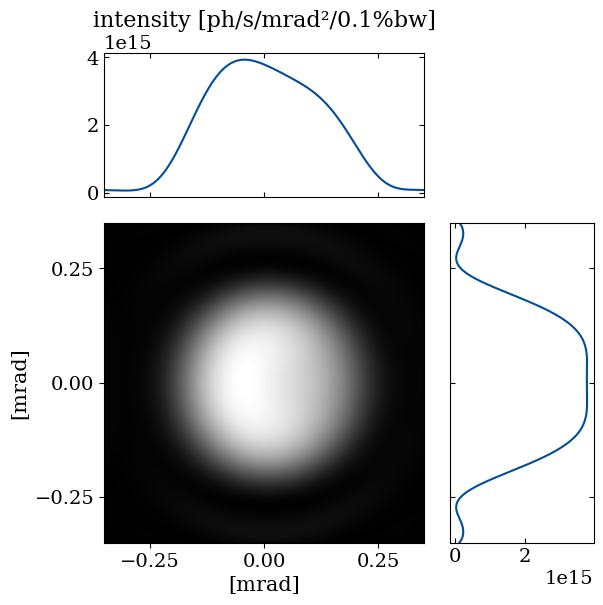

> Beam at ± 3 sigma:
>>> 1.19 mrad (horizontal cut)
>>> 1.30 mrad (vertical cut)
> Beam at ± (first ring)*0.71:
>>> 1.39 mrad


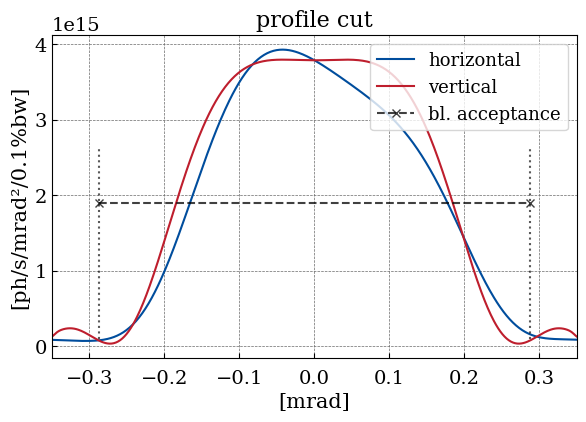

Undulator power density spatial distribution using SRW. Please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ... completed
> Electron trajectory calculation ... completed
> Undulator power density spatial distribution using SRW ... completed
Total received power: 186.963 W
Peak power density: 3.340 W/mm^2
Undulator power density spatial distribution using SRW: finished
>> Total elapsed time: 33.46 s


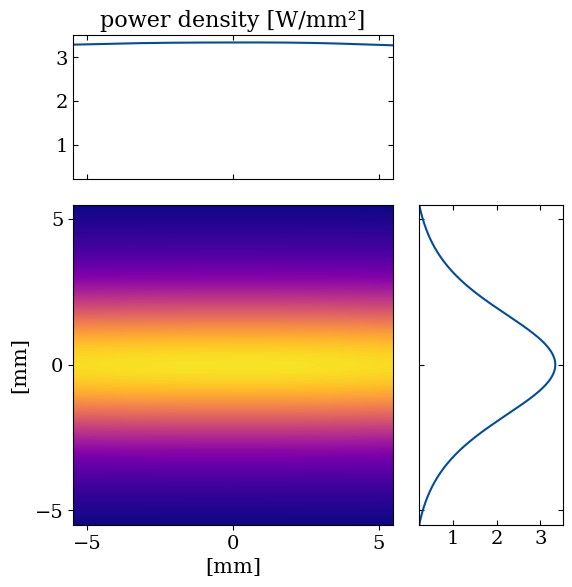

Power emitted by the undulator through a 0.57 x 0.57 mrad² slit: 186.963 W
>> 175.572 W using beamline.get_power_through_slit()
Undulator spectrum calculation using SRW: please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ... completed
> Electron trajectory calculation ... completed
>>> generate_logarithmic_energy_values - number of steps: 5220 (-219.0 and 5001.0) around E0 with step size 1.632e-03
> Performing flux through finite aperture (simplified partially-coherent simulation) in parallel... 


KeyboardInterrupt: 

In [23]:
E = 10
nharm = int(fE/E)
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)
if power: power_profile(beamline, angular_acceptance, slit_position)
if spectrum: slit_spectrum(beamline, E, nharm, dE, np.min([angular_acceptance, 2*beamline.first_ring/np.sqrt(2)]), slit_position, energy_sampling=1, fmin=20, fmax=25000, pt_min=0.5E12, pt_max=1E16)
if spectrum: slit_spectrum(beamline, E, nharm, dE, 0.2E-3, slit_position, energy_sampling=1, fmin=20, fmax=25000, pt_min=0.5E12, pt_max=1E16)

In [ ]:
E = 30
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)

In [ ]:
E = 70
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)

In [ ]:
E = 280
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)

## phase 1 source: HU60

In [ ]:
beamline = upgraded_bl_hu60
angular_acceptance = np.amin([window_v[2], window_h[2], design_aperture])

In [ ]:
E = 70
nharm = int(fE/E)
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)
if power: power_profile(beamline, angular_acceptance, slit_position)
if spectrum: slit_spectrum(beamline, E, nharm, dE, np.min([angular_acceptance, 2*beamline.first_ring/np.sqrt(2)]), slit_position, energy_sampling=1, fmin=20, fmax=25000, pt_min=0.5E12, pt_max=1E16)
if spectrum: slit_spectrum(beamline, E, nharm, dE, 0.2E-3, slit_position, energy_sampling=1, fmin=20, fmax=25000, pt_min=0.5E12, pt_max=1E16)

In [ ]:
E = 280
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)

In [ ]:
E = 500
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)

In [ ]:
E = 900
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)

In [ ]:
E = 1000
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)

## phase 1 source: HU80

In [ ]:
beamline = upgraded_bl_hu80
angular_acceptance = np.amin([window_v[3], window_h[3], design_aperture])

In [ ]:
E = 30
nharm = int(fE/E)
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)
if power: power_profile(beamline, angular_acceptance, slit_position)
if spectrum: slit_spectrum(beamline, E, nharm, dE, np.min([angular_acceptance, 2*beamline.first_ring/np.sqrt(2)]), slit_position, energy_sampling=1, fmin=20, fmax=25000, pt_min=0.5E12, pt_max=1E16)
if spectrum: slit_spectrum(beamline, E, nharm, dE, 0.2E-3, slit_position, energy_sampling=1, fmin=20, fmax=25000, pt_min=0.5E12, pt_max=1E16)

In [ ]:
E = 70
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)

In [ ]:
E = 280
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)

In [ ]:
E = 500
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)

In [ ]:
E = 900
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)

In [ ]:
E = 1000
beamline.set_undulator(wavelength=energy_wavelength(E, unity='eV'), direction='v', verbose=True, harmonic=harmonic)
if wavefront: emission_profile(beamline, E, angular_window, slit_position, angular_acceptance=angular_acceptance)

<a id="tc"></a>
# Advanced tuning curves
***

[Back to the top](#toc)

In [ ]:
def advanced_tuning_curve(beamline, energy_array, nharm, angular_acceptance, slit_position, **kwargs):

    Kmin = kwargs.get('Kmin', 0.05)
    Kmax = kwargs.get('Kmax', None)
    fraction = kwargs.get('fraction', 1/np.sqrt(2))
    from_wavefront = kwargs.get('from_wavefront', False)
    total_power = kwargs.get('total_power', False)
    calculate_beam_size = kwargs.get('beam_size', False)
    fixed_slit = kwargs.get('fixed_slit', False)

    observation_point = slit_position - beamline.centre

    K = np.zeros((len(energy_array), nharm)) if nharm > 1 else np.zeros(len(energy_array))
    power = np.zeros((len(energy_array), nharm)) if nharm > 1 else np.zeros(len(energy_array))

    flux = { 
        'from_spectrum': np.zeros((len(energy_array), nharm)) if nharm > 1 else np.zeros(len(energy_array)),
        'from_wavefront': np.zeros((len(energy_array), nharm)) if nharm > 1 else np.zeros(len(energy_array)),
        'from_central_cone': np.zeros((len(energy_array), nharm)) if nharm > 1 else np.zeros(len(energy_array)),
    }

    ang_accpt_dict = {
        'fraction': fraction,
        'horizontal': np.zeros((len(energy_array), nharm)) if nharm > 1 else np.zeros(len(energy_array)),
        'vertical': np.zeros((len(energy_array), nharm)) if nharm > 1 else np.zeros(len(energy_array)),
        'first_ring': np.zeros((len(energy_array), nharm)) if nharm > 1 else np.zeros(len(energy_array)),
        'angular_acceptance': np.zeros((len(energy_array), nharm)) if nharm > 1 else np.zeros(len(energy_array)),
    }

    even_harmonics = False
    for harmonic in range(nharm):
        for i, eng in enumerate(energy_array):
            harm, deflection_parameter = und.find_emission_harmonic_and_K(eng, 
                                                                          beamline.period_length, 
                                                                          beamline.energy_in_GeV, 
                                                                          Kmin, 
                                                                          0, 
                                                                          harmonic+1, 
                                                                          even_harmonics=even_harmonics)  
            if harm == harmonic+1:
                if K.ndim == 2:
                    if harm % 2 != 0:
                        K[i, harmonic] = deflection_parameter

                else:
                    if harm % 2 != 0:
                        K[i] = deflection_parameter

    if Kmax is None:
        Kmax = K[0, 0] if K.ndim == 2 else K[0]
    
    K[K>Kmax] = 0
    K[K<Kmin] = 0
    
    for harmonic in range(nharm):
        for i, dE in enumerate(energy_array):
            current_K = K[i, harmonic] if K.ndim == 2 else K[i]
            if current_K>0:
                beamline.set_undulator(wavelength=energy_wavelength(dE, unity='eV'),
                                       direction='v', verbose=True, harmonic=harmonic+1)
                first_ring = 2*beamline.first_ring*fraction

                if calculate_beam_size:
                    window = np.tan(first_ring/2)*observation_point*2
                    wavefront = und.emitted_wavefront(file_name=None,
                                    photon_energy=dE,
                                    light_source=beamline,
                                    hor_slit=window,
                                    ver_slit=window,
                                    hor_slit_n=501,
                                    ver_slit_n=501,
                                    observation_point=observation_point)
                    
                    wft_dict = wavefront_fwxm(wavefront["wavefront"]["intensity"],
                                x=wavefront["axis"]["x"],
                                y=wavefront["axis"]["y"],
                                xth=-1, k=6)

                    if K.ndim == 2:
                        ang_accpt_dict['horizontal'][i, harmonic] = np.arctan(wft_dict['horizontal']['fwxm']/observation_point)
                        ang_accpt_dict['vertical'][i, harmonic] = np.arctan(wft_dict['vertical']['fwxm']/observation_point)
                    else:
                        ang_accpt_dict['horizontal'][i] = np.arctan(wft_dict['horizontal']['fwxm']/observation_point)
                        ang_accpt_dict['vertical'][i] = np.arctan(wft_dict['vertical']['fwxm']/observation_point)
                   
                if fixed_slit is True:
                    angular_window = angular_acceptance
                elif first_ring > angular_acceptance:
                    angular_window = angular_acceptance
                else:
                    angular_window = first_ring

                window = np.tan(angular_window/2)*observation_point*2

                spectrum = und.spectrum(file_name=None,
                        light_source=beamline,
                        photon_energy_min=dE,
                        photon_energy_max=dE*5.3,
                        photon_energy_points=501,
                        observation_point=observation_point,
                        hor_slit=window,
                        ver_slit=window,
                        parallel = False,
                        **kwargs)
                from_spectrum = spectrum["spectrum"]["flux"][0]
                from_central_cone = beamline.central_cone_flux

                if from_wavefront:
                    wavefront = und.emitted_wavefront(file_name=None,
                                    photon_energy=dE,
                                    light_source=beamline,
                                    hor_slit=window,
                                    ver_slit=window,
                                    hor_slit_n=501,
                                    ver_slit_n=501,
                                    observation_point=observation_point)
                    dx = (wavefront['axis']['x'][1] - wavefront['axis']['x'][0]) * 1E3
                    dy = (wavefront['axis']['y'][1] - wavefront['axis']['y'][0]) * 1E3
                    from_wavefront = np.sum(dx*dy*wavefront["wavefront"]["intensity"])
                else:
                    from_wavefront = None

                if total_power:
                     PowDen = beamline.get_power_through_slit(angular_window, angular_window, npix=251)
                else:
                    PowDen = None

                if K.ndim == 2:
                    flux['from_spectrum'][i, harmonic] = from_spectrum
                    flux['from_wavefront'][i, harmonic] = from_wavefront
                    flux['from_central_cone'][i, harmonic] = from_central_cone
                    power[i, harmonic] = PowDen
                    ang_accpt_dict['first_ring'][i, harmonic] = first_ring
                    ang_accpt_dict['angular_acceptance'][i, harmonic] = angular_window
                else:
                    flux['from_spectrum'][i] = from_spectrum
                    flux['from_wavefront'][i] = from_wavefront
                    flux['from_central_cone'][i] = from_central_cone
                    power[i] = PowDen
                    ang_accpt_dict['first_ring'][i] = first_ring
                    ang_accpt_dict['angular_acceptance'][i] = angular_window

    return {'flux':flux, 'power': power, 'angular_acceptance': ang_accpt_dict, 'energy': energy_array}

In [ ]:
nharm = 1
energy_array = np.linspace(10, 1010, 101)
total_power = True

In [ ]:
energy_array = np.linspace(10, 1010, 21)

In [ ]:
beamline = current_he_bl
beamline.set_undulator(wavelength=energy_wavelength(70, unity='eV'), direction='v', verbose=True, harmonic=1)
angular_acceptance = np.amin([window_v[0], window_h[0], design_aperture])
current_he_bl_tc = advanced_tuning_curve(beamline, energy_array, nharm, angular_acceptance, slit_position, Kmax=beamline.K_vertical)

In [ ]:
beamline = current_le_bl
beamline.set_undulator(wavelength=energy_wavelength(10, unity='eV'), direction='v', verbose=True, harmonic=1)
angular_acceptance = np.amin([window_v[1], window_h[1], design_aperture])
current_le_bl_tc = advanced_tuning_curve(beamline, energy_array, nharm, angular_acceptance, slit_position, Kmax=beamline.K_vertical)

In [ ]:
beamline = upgraded_bl_hu60
beamline.set_undulator(wavelength=energy_wavelength(70, unity='eV'), direction='v', verbose=True, harmonic=1)
angular_acceptance = np.amin([window_v[2], window_h[2], design_aperture])
upgraded_bl_hu60_tc = advanced_tuning_curve(beamline, energy_array, nharm, angular_acceptance, slit_position, Kmax=beamline.K_vertical)

In [ ]:
beamline = upgraded_bl_hu80
beamline.set_undulator(wavelength=energy_wavelength(30, unity='eV'), direction='v', verbose=True, harmonic=1)
angular_acceptance = np.amin([window_v[3], window_h[3], design_aperture])
upgraded_bl_hu80_tc = advanced_tuning_curve(beamline, energy_array, nharm, angular_acceptance, slit_position, Kmax=beamline.K_vertical)

## Results

In [ ]:
labels = 'HU60', 'HU256', 'HU60-II', 'HU80-II'
tc = [current_he_bl_tc, current_le_bl_tc, upgraded_bl_hu60_tc, upgraded_bl_hu80_tc]
clrs = [2, 5, 1, 0]
symbols = [">", "^", "<", "v"]
ordinals = ["st", "nd", "rd", "th"]
xmin = -100
xmax = 1200

In [ ]:
fig = PlotManager()
for idx, label in enumerate(labels):
    for harmonic in range(nharm):
        if harmonic == 1:
            pass
        else:
            plt_label = None
            if nharm>1:
                beam_shape = tc[idx]['angular_acceptance']['angular_acceptance'][:,harmonic]*1E3
                plt_label = f"{label} ({harmonic+1} {ordinals[harmonic]})"
            else:
                beam_shape = tc[idx]['angular_acceptance']['angular_acceptance'][:]*1E3
                plt_label = f"{label}"

            beam_shape[beam_shape==0] = np.nan
            fig.image, fig.x = beam_shape, energy_array
            fig.additional_info("slit", "[eV]",  "[mrad]", xmin=xmin, xmax=xmax).aesthetics(LaTex=True, grid=True, PlotScale=0)
            hold = False if (harmonic==0 and idx==0) else True
            enable = True if (harmonic==nharm-1 and idx==len(labels)-1) else False
            fig.info_1d_plot(clrs[idx], plt_label, LineStyle=symbols[idx], LabelPos=1, alpha=1).plot_1d(enable=enable, hold=hold, m=8.0)

In [ ]:
types_of_flux = ['from_spectrum']

for flux in types_of_flux:
    fig = PlotManager()
    for idx, label in enumerate(labels):
        for harmonic in range(nharm):
            if harmonic == 1:
                pass
            else:
                plt_label = None
                if nharm>1:
                    beam_shape = tc[idx]['flux'][flux][:,harmonic]
                    plt_label = f"{label} ({harmonic+1} {ordinals[harmonic]})"
                else:
                    beam_shape = tc[idx]['flux'][flux][:]
                    plt_label = f"{label}"
                beam_shape[beam_shape==0] = np.nan
                fig.image, fig.x = beam_shape, energy_array
                fig.additional_info("on-resonance flux (slit)", "[eV]",  "[ph/s/0.1% bw]", xmin=xmin, xmax=xmax).aesthetics(LaTex=True, grid=True, PlotScale=0)
                hold = False if (harmonic==0 and idx==0) else True
                enable = True if (harmonic==nharm-1 and idx==len(labels)-1) else False
                fig.info_1d_plot(clrs[idx], plt_label, LineStyle=symbols[idx], LabelPos=1, alpha=1).plot_1d(enable=enable, hold=hold, m=8.0)

In [ ]:
for flux in types_of_flux:
    he_bl_flux = current_he_bl_tc['flux'][flux]
    le_bl_flux = current_le_bl_tc['flux'][flux]
    bl_hu60_sii_flux = upgraded_bl_hu60_tc['flux'][flux]
    bl_hu80_sii_flux = upgraded_bl_hu80_tc['flux'][flux]

    he_bl_flux[he_bl_flux==0] = np.nan
    le_bl_flux[le_bl_flux==0] = np.nan
    bl_hu60_sii_flux[bl_hu60_sii_flux==0] = np.nan
    bl_hu80_sii_flux[bl_hu80_sii_flux==0] = np.nan

    g_he_hu60 = (bl_hu60_sii_flux/he_bl_flux)
    g_le_hu60 = (bl_hu60_sii_flux/le_bl_flux)

    g_he_hu80 = (bl_hu80_sii_flux/he_bl_flux)
    g_le_hu80 = (bl_hu80_sii_flux/le_bl_flux)

    img = PlotManager(g_he_hu60, energy_array)
    img.additional_info("on resonance gain", "[eV]",  "[a.u.]", xmin=xmin, xmax=xmax, ymin =None, ymax=None)
    img.aesthetics(400, True, True, 0 , 1, True, 4).info_1d_plot(3, "HU60-II/HU60", 0, symbols[0], False, 0, 1).plot_1d(enable=False, m=8)
    img.image = g_he_hu80
    img.info_1d_plot(4, "HU80-II/HU256", 0, symbols[2], False, 0, 1).plot_1d(enable=True, hold=True)

    img = PlotManager(g_le_hu60, energy_array)
    img.additional_info("on resonance gain", "[eV]",  "[a.u.]", xmin=xmin, xmax=xmax, ymin =None, ymax=None)
    img.aesthetics(400, True, True, 0 , 1, True, 4).info_1d_plot(3, "HU60-II/HU60", 0, symbols[0], False, 0, 1).plot_1d(enable=False, m=8)
    img.image = g_le_hu80
    img.info_1d_plot(4, "HU80-II/HU256", 0, symbols[2], False, 0, 1).plot_1d(enable=True, hold=True)


In [ ]:
fig = PlotManager()
for idx, label in enumerate(labels):
    for harmonic in range(nharm):
        if harmonic == 1:
            pass
        else:
            plt_label = None
            if nharm>1:
                beam_shape = tc[idx]['power'][:,harmonic]
                plt_label = f"{label} ({harmonic+1} {ordinals[harmonic]})"
            else:
                beam_shape = tc[idx]['power'][:]
                plt_label = f"{label}"
            
            beam_shape[beam_shape==0] = np.nan
            fig.image, fig.x = beam_shape, energy_array
            fig.additional_info("integrated power", "[eV]",  "[W]", xmin=xmin, xmax=xmax).aesthetics(LaTex=True, grid=True, PlotScale=0)
            hold = False if (harmonic==0 and idx==0) else True
            enable = True if (harmonic==nharm-1 and idx==len(labels)-1) else False
            fig.info_1d_plot(clrs[idx], plt_label, LineStyle=symbols[harmonic], LabelPos=1, alpha=1).plot_1d(enable=enable, hold=hold, m=8)


## Comparison with 0.2x0.2 mrad² aperture

In [ ]:
angular_acceptance = 0.2e-3
total_power=False

In [ ]:
beamline = current_he_bl
beamline.set_undulator(wavelength=energy_wavelength(70, unity='eV'), direction='v', verbose=True, harmonic=1)
current_he_bl_tc = advanced_tuning_curve(beamline, energy_array, nharm, angular_acceptance, slit_position, Kmax=beamline.K_vertical, total_power=total_power, fixed_slit=True)

In [ ]:
beamline = current_le_bl
beamline.set_undulator(wavelength=energy_wavelength(10, unity='eV'), direction='v', verbose=True, harmonic=1)
current_le_bl_tc = advanced_tuning_curve(beamline, energy_array, nharm, angular_acceptance, slit_position, Kmax=beamline.K_vertical, total_power=total_power, fixed_slit=True)

In [ ]:
beamline = upgraded_bl_hu60
beamline.set_undulator(wavelength=energy_wavelength(70, unity='eV'), direction='v', verbose=True, harmonic=1)
upgraded_bl_hu60_tc = advanced_tuning_curve(beamline, energy_array, nharm, angular_acceptance, slit_position, Kmax=beamline.K_vertical, total_power=total_power, fixed_slit=True)

In [ ]:
beamline = upgraded_bl_hu80
beamline.set_undulator(wavelength=energy_wavelength(30, unity='eV'), direction='v', verbose=True, harmonic=1)
upgraded_bl_hu80_tc = advanced_tuning_curve(beamline, energy_array, nharm, angular_acceptance, slit_position, Kmax=beamline.K_vertical, total_power=total_power, fixed_slit=True)

## Results

In [ ]:
tc = [current_he_bl_tc, current_le_bl_tc, upgraded_bl_hu60_tc, upgraded_bl_hu80_tc]

In [ ]:
fig = PlotManager()
for idx, label in enumerate(labels):
    for harmonic in range(nharm):
        if harmonic == 1:
            pass
        else:
            plt_label = None
            if nharm>1:
                beam_shape = tc[idx]['angular_acceptance']['angular_acceptance'][:,harmonic]*1E3
                plt_label = f"{label} ({harmonic+1} {ordinals[harmonic]})"
            else:
                beam_shape = tc[idx]['angular_acceptance']['angular_acceptance'][:]*1E3
                plt_label = f"{label}"

            beam_shape[beam_shape==0] = np.nan
            fig.image, fig.x = beam_shape, energy_array
            fig.additional_info("slit", "[eV]",  "[mrad]", xmin=xmin, xmax=xmax).aesthetics(LaTex=True, grid=True, PlotScale=0)
            hold = False if (harmonic==0 and idx==0) else True
            enable = True if (harmonic==nharm-1 and idx==len(labels)-1) else False
            fig.info_1d_plot(clrs[idx], plt_label, LineStyle=symbols[idx], LabelPos=1, alpha=1).plot_1d(enable=enable, hold=hold, m=8.0)

In [ ]:
types_of_flux = ['from_spectrum']

for flux in types_of_flux:
    fig = PlotManager()
    for idx, label in enumerate(labels):
        for harmonic in range(nharm):
            if harmonic == 1:
                pass
            else:
                plt_label = None
                if nharm>1:
                    beam_shape = tc[idx]['flux'][flux][:,harmonic]
                    plt_label = f"{label} ({harmonic+1} {ordinals[harmonic]})"
                else:
                    beam_shape = tc[idx]['flux'][flux][:]
                    plt_label = f"{label}"
                beam_shape[beam_shape==0] = np.nan
                fig.image, fig.x = beam_shape, energy_array
                fig.additional_info("on-resonance flux (slit)", "[eV]",  "[ph/s/0.1% bw]", xmin=xmin, xmax=xmax).aesthetics(LaTex=True, grid=True, PlotScale=0)
                hold = False if (harmonic==0 and idx==0) else True
                enable = True if (harmonic==nharm-1 and idx==len(labels)-1) else False
                fig.info_1d_plot(clrs[idx], plt_label, LineStyle=symbols[idx], LabelPos=1, alpha=1).plot_1d(enable=enable, hold=hold, m=8.0)

In [ ]:
for flux in types_of_flux:
    he_bl_flux = current_he_bl_tc['flux'][flux]
    le_bl_flux = current_le_bl_tc['flux'][flux]
    bl_hu60_sii_flux = upgraded_bl_hu60_tc['flux'][flux]
    bl_hu80_sii_flux = upgraded_bl_hu80_tc['flux'][flux]

    he_bl_flux[he_bl_flux==0] = np.nan
    le_bl_flux[le_bl_flux==0] = np.nan
    bl_hu60_sii_flux[bl_hu60_sii_flux==0] = np.nan
    bl_hu80_sii_flux[bl_hu80_sii_flux==0] = np.nan

    g_he_hu60 = (bl_hu60_sii_flux/he_bl_flux)
    g_le_hu60 = (bl_hu60_sii_flux/le_bl_flux)

    g_he_hu80 = (bl_hu80_sii_flux/he_bl_flux)
    g_le_hu80 = (bl_hu80_sii_flux/le_bl_flux)

    img = PlotManager(g_he_hu60, energy_array)
    img.additional_info("on resonance gain", "[eV]",  "[a.u.]", xmin=xmin, xmax=xmax, ymin =None, ymax=None)
    img.aesthetics(400, True, True, 0 , 1, True, 4).info_1d_plot(3, "HU60-II/HU60", 0, symbols[0], False, 0, 1).plot_1d(enable=False, m=8)
    img.image = g_he_hu80
    img.info_1d_plot(4, "HU80-II/HU256", 0, symbols[2], False, 0, 1).plot_1d(enable=True, hold=True)

    img = PlotManager(g_le_hu60, energy_array)
    img.additional_info("on resonance gain", "[eV]",  "[a.u.]", xmin=xmin, xmax=xmax, ymin =None, ymax=None)
    img.aesthetics(400, True, True, 0 , 1, True, 4).info_1d_plot(3, "HU60-II/HU60", 0, symbols[0], False, 0, 1).plot_1d(enable=False, m=8)
    img.image = g_le_hu80
    img.info_1d_plot(4, "HU80-II/HU256", 0, symbols[2], False, 0, 1).plot_1d(enable=True, hold=True)


In [ ]:
fig = PlotManager()
for idx, label in enumerate(labels):
    for harmonic in range(nharm):
        if harmonic == 1:
            pass
        else:
            plt_label = None
            if nharm>1:
                beam_shape = tc[idx]['power'][:,harmonic]
                plt_label = f"{label} ({harmonic+1} {ordinals[harmonic]})"
            else:
                beam_shape = tc[idx]['power'][:]
                plt_label = f"{label}"
            
            beam_shape[beam_shape==0] = np.nan
            fig.image, fig.x = beam_shape, energy_array
            fig.additional_info("integrated power", "[eV]",  "[W]", xmin=xmin, xmax=xmax).aesthetics(LaTex=True, grid=True, PlotScale=0)
            hold = False if (harmonic==0 and idx==0) else True
            enable = True if (harmonic==nharm-1 and idx==len(labels)-1) else False
            fig.info_1d_plot(clrs[idx], plt_label, LineStyle=symbols[harmonic], LabelPos=1, alpha=1).plot_1d(enable=enable, hold=hold, m=8)
